In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from numpy import dot
from numpy.linalg import norm
from math import *
from collections import Counter
import datetime as dt
import csv

In [2]:
# playing around with automation processed in order to apply the algorithm on the export from the BO
'''# extract datetime to use in the excel filename
now = dt.dt.now()
year = now.year
month = now.month
day = now.day

excel_filename = 'apartments-' + str(year) + '-' + str(month) + '-' + str(day) + '.xls'

print(excel_filename)
# 
'''
# load the excel sheet into a dataframe
df = pd.read_excel('./apartments.xls', index_col='id')

# df.rename(columns={'Id': 'id', 'Type': 'type', 'Rooms': 'rooms', 'Floor': 'floor', 'Max Floor' : 'max_floor', 'Size' : 'size', 'No. Balconies' : 'no_balconies', 'Size Balconies (Total)': 'size_balconies_total', 'Yard Size': 'yard_size', 'Construction Year': 'construction_year', 'Storage Size': 'storage_size', 'No. Elevators': 'no_elevators', 'No.Parking': 'no_parking', 'Price': 'price', 'Squared Meter Price': 'squared_meter_price', 'Property Tax': 'property_tax', 'Maintenance Fee': 'maintenance_fee', 'Condition': 'condition', 'Photos existence': 'photos_existence', 'City': 'city', 'Address':'address', 'Admin':'admin', 'Agent':'agent', 'Seller':'seller', 'Seller Phone':'seller_phone', 'Seller Email':'seller_email', 'Title':'title', 'Status':'status', 'Created':'created'}, inplace=True)

In [3]:
# use only 'published' entries
df = df[df.status == 'Published']

In [4]:
# initialize the 'squared_meter_price' col with correct values
df['squared_meter_price'] = df['price'].divide(df['size'])

df['condition'].value_counts(dropna=False)

משופצת              83
חדשה מקבלן          79
שמורה               65
חדשה (עד 5 שנים)    37
דורשת שיפוץ         14
NaN                  2
Name: condition, dtype: int64

In [5]:
# irrelevant fields
df = df.drop('seller_email', axis=1)
df = df.drop('seller_phone', axis=1)
df = df.drop('title', axis=1)
df = df.drop('created', axis=1)
df = df.drop('admin', axis=1)
df = df.drop('address', axis=1)
df = df.drop('agent', axis=1)
df = df.drop('seller', axis=1)
df = df.drop('photos_existence', axis=1)
df = df.drop('date_published', axis=1)
df = df.drop('price_published', axis=1)
df = df.drop('date_sold', axis=1)
df = df.drop('price_sold', axis=1)

# df = df.drop('Unnamed: 29', axis=1)

# to be corrected soon
# df = df.drop('squared_meter_price', axis=1)
df = df.drop('condition', axis=1)


# slightly missing fields
df = df.drop('property_tax', axis=1)
df = df.drop('maintenance_fee', axis=1)
df = df.drop('construction_year', axis=1)

# Fill the NaN with the proper values

In [6]:
# Format the representation of floats
pd.options.display.float_format = '{:,.6f}'.format

# fill NaN with 0's where needed
df.floor.fillna(0, inplace=True)
df.rooms.fillna(0, inplace=True)
df.max_floor.fillna(0, inplace=True)
df['size'].fillna(0, inplace=True)
df.no_balconies.fillna(0, inplace=True)
df.size_balconies_total.fillna(0, inplace=True)
df.yard_size.fillna(0, inplace=True)
df.storage_size.fillna(0, inplace=True)
df.no_elevators.fillna(0, inplace=True)
df.no_parking.fillna(0, inplace=True)

df.head()

,type,rooms,floor,max_floor,size,no_balconies,size_balconies_total,yard_size,storage_size,no_elevators,no_parking,price,squared_meter_price,city,status
id,,,,,,,,,,,,,,,
1,פנטהאוז/דירת גג,4.000000,2.000000,2.000000,148.000000,1.000000,70.000000,0.000000,0.000000,2.000000,2.000000,"10,500,000.000000","70,945.945946",הרצליה,Published
2,דירת גן,4.000000,1.000000,2.000000,140.000000,0.000000,25.000000,168.000000,0.000000,2.000000,2.000000,"8,500,000.000000","60,714.285714",הרצליה,Published
4,דירה,3.000000,2.000000,2.000000,70.000000,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000,"2,600,000.000000","37,142.857143",גבעתיים,Published
6,דירה,3.000000,10.000000,25.000000,83.000000,1.000000,17.000000,0.000000,6.000000,4.000000,1.000000,"2,950,000.000000","35,542.168675",רמת גן,Published
7,דירה,2.000000,2.000000,2.000000,75.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"1,870,000.000000","24,933.333333",רמת גן,Published


In [7]:
# presents how many rows and columns in the df
df.shape

# extract the number of entries
leng = df.shape
length_x = leng[0]

# extract the array of the id's in order to use it in the excel sheet
id_array = df.index.values

In [8]:
# print information regarding each column in the df
# df.info()

''' 
Full or nearly-full:
• type
• rooms
• floor - NaN values are almost always ground houses
• max_floor - same as floor, missing some data (14 apts)
• size
• no_balconies - NaN values are almost always apts without balconies
• size_balconies_total - same as no_balconies
• yard_size - NaN values are apts without yard
• storage_size - same as yard size
• no_elevators - NaN values lack an elevator
• no_parking - NaN values lack a parking
• price
• squared_meter_price
• condition - POSSIBLY PROBLEMATIC WITH 'חדשה מקבלן'
• city
• address - will be added a LONGTITUDE and LATITUDE field in order to place on map


Slightly missing:
• construction_year - important but lack information
• property_tax - most experts don't fill this field
• maintenance_fee - same as property tax
• 

Could be irrelevant:
• admin
• seller
• seller_phone
• seller_email
• title
• created
• agent

To be added:
• long & lat
• neighborhood


* work was done only on apts with df['status'] == 'Published'
'''

# df.describe()

" \nFull or nearly-full:\n• type\n• rooms\n• floor - NaN values are almost always ground houses\n• max_floor - same as floor, missing some data (14 apts)\n• size\n• no_balconies - NaN values are almost always apts without balconies\n• size_balconies_total - same as no_balconies\n• yard_size - NaN values are apts without yard\n• storage_size - same as yard size\n• no_elevators - NaN values lack an elevator\n• no_parking - NaN values lack a parking\n• price\n• squared_meter_price\n• condition - POSSIBLY PROBLEMATIC WITH 'חדשה מקבלן'\n• city\n• address - will be added a LONGTITUDE and LATITUDE field in order to place on map\n\n\nSlightly missing:\n• construction_year - important but lack information\n• property_tax - most experts don't fill this field\n• maintenance_fee - same as property tax\n• \n\nCould be irrelevant:\n• admin\n• seller\n• seller_phone\n• seller_email\n• title\n• created\n• agent\n\nTo be added:\n• long & lat\n• neighborhood\n\n\n* work was done only on apts with df['st

In [9]:
# create numeric values from categorical values - type
df = pd.concat([df, pd.get_dummies(df['type']), pd.get_dummies(df.city)], axis=1)

# Scale the data to [0,1]

In [10]:
# create a copy of the DataFrame
df_scaled = pd.DataFrame(data=df)

###  Scaling [0,1] process:  ### 
# scale the data to a [0, 1] scale, update on the new DataFrame
''' floor scaling: '''
df_scaled.floor = (df.floor - df.floor.min()) / (df.floor.max() - df.floor.min())

''' rooms scaling: '''
df_scaled.rooms = (df.rooms - df.rooms.min()) / (df.rooms.max() - df.rooms.min())

''' max_floor scaling: '''
df_scaled.max_floor = (df.max_floor - df.max_floor.min()) / (df.max_floor.max() - df.max_floor.min())

''' size scaling: '''
df_scaled['size'] = (df['size'] - df['size'].min()) / (df['size'].max() - df['size'].min())

''' no_balconies scaling: '''
df_scaled.no_balconies = (df.no_balconies - df.no_balconies.min()) / (df.no_balconies.max() - df.no_balconies.min())

''' size_balconies_total scaling: '''
df_scaled.size_balconies_total = (df.size_balconies_total - df.size_balconies_total.min()) / (df.size_balconies_total.max() - df.size_balconies_total.min())

''' yard_size scaling: '''
df_scaled.yard_size = (df.yard_size - df.yard_size.min()) / (df.yard_size.max() - df.yard_size.min())

''' storage_size scaling: '''
df_scaled.storage_size = (df.storage_size - df.storage_size.min()) / (df.storage_size.max() - df.storage_size.min())

''' no_elevators scaling: '''
df_scaled.no_elevators = (df.no_elevators - df.no_elevators.min()) / (df.no_elevators.max() - df.no_elevators.min())

''' no_parking scaling: '''
df_scaled.no_parking = (df.no_parking - df.no_parking.min()) / (df.no_parking.max() - df.no_parking.min())

''' price scaling: '''
df_scaled.price = (df.price - df.price.min()) / (df.price.max() - df.price.min())

''' squared_meter_price scaling: '''
df_scaled.squared_meter_price = (df.squared_meter_price - df.squared_meter_price.min()) / (df.squared_meter_price.max() - df.squared_meter_price.min())

# scale the data to a [-1, 1] scale
scaled_minus1_1_floor = ((2 * (df.floor - df.floor.min())) / (df.floor.max() - df.floor.min())) - 1

# concat the 2 new scaled df's into the original one
#df = pd.concat([df, scaled_minus1_1_floor, scaled_floor], axis=1)

# Apply the weights to the features

In [11]:
# apply the weights to the parameters
''' floor weights: '''  
df_scaled.floor = df_scaled.floor * 0.06

''' rooms weights: '''
df_scaled.rooms = df_scaled.rooms * 0.2

''' max_floor weights: '''
df_scaled.max_floor = df_scaled.max_floor * 0.015

''' size weights: '''
df_scaled['size'] = df_scaled['size'] * 0.18

''' no_balconies weights: '''
df_scaled.no_balconies = df_scaled.no_balconies * 0.005

''' size_balconies_total weights: '''
df_scaled.size_balconies_total = df_scaled.size_balconies_total * 0.015

''' yard_size weights: '''
df_scaled.yard_size = df_scaled.yard_size * 0.01

''' storage_size weights: '''
df_scaled.storage_size = df_scaled.storage_size * 0.01

''' no_elevators weights: '''
df_scaled.no_elevators = df_scaled.no_elevators * 0.02

''' no_parking weights: '''
df_scaled.no_parking = df_scaled.no_parking * 0.02

''' price weights: '''
df_scaled.price = df_scaled.price * 0.235

''' squared_meter_price weights: '''
df_scaled.squared_meter_price = df_scaled.squared_meter_price * 0.1

''' city weights: '''
# weights are implemented on each city - total weights
df_scaled['בצרה'] = df_scaled['בצרה'] * 0.135
df_scaled['בת ים'] = df_scaled['בת ים'] * 0.135
df_scaled['גבעת שמואל'] = df_scaled['גבעת שמואל'] * 0.135
df_scaled['גבעתיים'] = df_scaled['גבעתיים'] * 0.135
df_scaled['הוד השרון'] = df_scaled['הוד השרון'] * 0.135
df_scaled['הרצליה'] = df_scaled['הרצליה'] * 0.135
df_scaled['חולון'] = df_scaled['חולון'] * 0.135 
df_scaled['נתניה'] = df_scaled['נתניה'] * 0.135
df_scaled['פתח תקווה'] = df_scaled['פתח תקווה'] * 0.135
df_scaled['קרית אונו'] = df_scaled['קרית אונו'] * 0.135
df_scaled['ראשון לציון'] = df_scaled['ראשון לציון'] * 0.135
df_scaled['רמת גן'] = df_scaled['רמת גן'] * 0.135
df_scaled['רמת השרון'] = df_scaled['רמת השרון'] * 0.135
df_scaled['תל אביב - יפו'] = df_scaled['תל אביב - יפו'] *0.135

''' type weights: '''
# apply the same for each type - 
df_scaled['דופלקס'] = df_scaled['דופלקס'] *0.015
df_scaled['דירה'] = df_scaled['דירה'] * 0.015
df_scaled['דירת גן'] = df_scaled['דירת גן'] * 0.015
df_scaled['סטודיו/לופט'] = df_scaled['סטודיו/לופט'] * 0.015
df_scaled['פנטהאוז/דירת גג'] = df_scaled['פנטהאוז/דירת גג'] * 0.015

# rename the columns in df_scaled
df_scaled.rename(columns={'rooms': 'rooms_scaled', 'floor': 'floor_scaled', 'max_floor' : 'max_floor_scaled', 'size' : 'size_scaled','no_balconies' : 'no_balconies_scaled', 'yard_size': 'yard_size_scaled', 'storage_size': 'storage_size_scaled', 'no_elevators': 'no_elevators_scaled', 'no_parking': 'no_parking_scaled', 'price': 'price_scaled'}, inplace=True)
    

In [12]:
# after scaling and completion, dismiss: type, city, status

df_scaled = df_scaled.drop('type', axis=1)
df_scaled = df_scaled.drop('city', axis=1)
df_scaled = df_scaled.drop('status', axis=1)

In [13]:
# define the euclidean distance function

def euclidean_distance(x,y):
    return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))


# define the cosine similarity funciton

def cos_sim(vector1, vector2) :
    cosine_sim = dot(vector1, vector2) / ((norm(vector1)*norm(vector2)))
    return cosine_sim

In [14]:
x = (1,2,3)
y = (4,5,6)

print(cos_sim(x,y))
print(euclidean_distance(x,y))

0.9746318461970762
5.196152422706632


In [15]:
from scipy.spatial import distance
a = (1, 2, 3)
b = (4, 5, 6)
dst = distance.euclidean(a, b)
print(dst)

5.196152422706632


In [16]:
# create a list from the dataFrame

df_list = df_scaled.values.tolist()
df_array = np.array(df_list)

In [17]:
'''euc = []

for row in df_array :
    for cell in df_array :
        euc.append(euclidean_distance(row, cell))

euc_mat= np.reshape(euc, (length_x, length_x))

# print(euc_mat)
df_euc_mat = pd.DataFrame(euc_mat)
#print(df_euc_mat)

print(euc_mat)
#print(df_array)'''


'euc = []\n\nfor row in df_array :\n    for cell in df_array :\n        euc.append(euclidean_distance(row, cell))\n\neuc_mat= np.reshape(euc, (length_x, length_x))\n\n# print(euc_mat)\ndf_euc_mat = pd.DataFrame(euc_mat)\n#print(df_euc_mat)\n\nprint(euc_mat)\n#print(df_array)'

# Create the similarity matrix

In [18]:
# initialize the array for the similarity matrix based on cosine similarity
data_cos = []

for row in df_array :
    for cell in df_array :
        # data.append((euclidean_distance(row,cell) + cos_sim(row, cell))) 
         data_cos.append(cos_sim(row, cell))
'''
# initialize the array for the similarity matrix based on euclidean distance
data_euc = []
for row in df_array :
    for cell in df_array :
         data_euc.append(euclidean_distance(row, cell))

# normalize the euclidean distance of all values
max_data_euc = max(data_euc)
data_euc = [x / max_data_euc for x in data_euc]
# print(data_euc)

# initialize the array for the similarity matrix based on both measures
data = []
data = [(x+y) for x,y in zip(data_cos, data_euc)]
'''
# reshape the 1-D array into an array of size (ENTRIES, ENTRIES)
sim_matrix = np.reshape(data_cos, (length_x, length_x))

In [19]:
# create a DataFrame from the similarity matrix in order to export it to excel

sim_matrix_df = pd.DataFrame(sim_matrix, index=id_array, columns=id_array)

In [20]:
# export the DataFrame containing the similarity matrix into an excel sheet named 'output.xlsx'

writer = pd.ExcelWriter('../RS/exports/output.xlsx')
sim_matrix_df.to_excel(writer, 'similarity matrix - cosine', columns=id_array)

writer2 = pd.ExcelWriter('../RS/exports/df_scaled.xlsx')
df_scaled.to_excel(writer2, 'df_scaled')

Text(69,0.5,'apartment id')

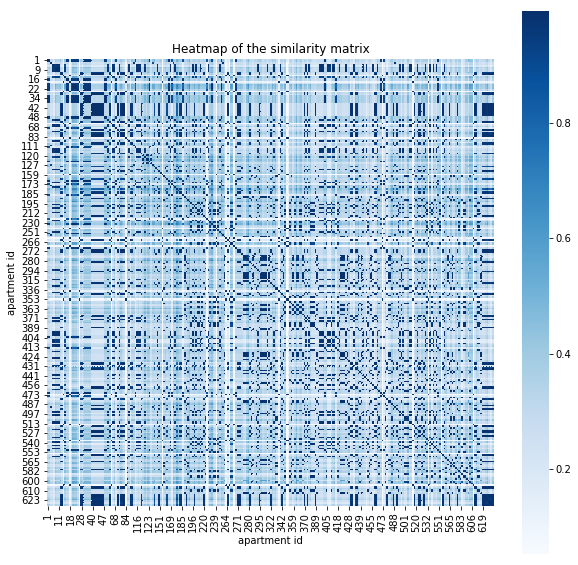

In [21]:
# plot a heatmap for the similarity matrix

plt.figure(figsize=(10, 10))
sns.heatmap(sim_matrix_df, robust=True, square=True, cmap="Blues")
plt.title('Heatmap of the similarity matrix')
plt.xlabel('apartment id')
plt.ylabel('apartment id')

In [22]:
dict_apartments_similarity = {}

for i in id_array :
    dict_apartments_similarity[i] = (sim_matrix_df.loc[i].sort_values(ascending=False).to_dict())
    
# print(dict_apartments_similarity[174])  

In [23]:
# initialize a dictionary for the call center data
call_center_dict = {}

# iterate over the dictionary in set pair of {apartment: top properties}
for key, value in dict_apartments_similarity.items():
    i_list = []
    for i in value :
        i_list.append(i)
    
    # take the properties that aren't the aprtment itself
    i_list_without_first = i_list.pop(0)
    call_center_dict[key] = i_list[:3]
    # print(call_center_dict[key])

# Create the call center report with top 3 properties

In [24]:
# create a pandas DataFrame from the call center dictionary
df_call_center = pd.DataFrame.from_dict(call_center_dict)
df_call_center = df_call_center.transpose()
df_call_center[0] = df_call_center[0].astype(str) + ', ' + df_call_center[1].astype(str) + ', ' + df_call_center[2].astype(str)

df_call_center = df_call_center[0]
# print(df_call_center[0])
'''
# Export the dictionary into a csv
w = csv.writer(open("../RS/exports/call_center.csv", "w"))
for key, val in call_center_dict.items():
    w.writerow([key, val])'''

'\n# Export the dictionary into a csv\nw = csv.writer(open("../RS/exports/call_center.csv", "w"))\nfor key, val in call_center_dict.items():\n    w.writerow([key, val])'

In [25]:
# Export the pandas dataframe with 5 top similar apartments into an excel sheet
writer_cs = pd.ExcelWriter('../RS/exports/call_center.xlsx')
df_call_center.to_excel(writer_cs, 'Top 5 similar apartments')
